# 2. RM(Reward Model) LoRA Rank 비교 실험

이 노트북은 사전 학습된 SFT 모델을 불러와 RM 단계만 실행합니다.
LoRA Rank 리스트 `[0, 8, 16]`에 대해 순차적으로 학습과 평가를 모두 수행하고, 마지막에 결과를 하나의 표로 요약합니다.

## 1. 라이브러리 임포트 및 로그인

In [1]:
import torch
import transformers
from transformers import AutoTokenizer
import json
import wandb
from typing import Optional, Dict, Sequence
from dataclasses import dataclass
import logging
import random
import torch.nn as nn
import gc

from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer.strategies import NaiveStrategy
from chatgpt.trainer.rm import RewardModelTrainer
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: beomyongchoi (beomyongchoi-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 2. 실험 파라미터 및 데이터 준비

In [2]:
# =========== 실험할 LoRA Rank 리스트 ===========
LORA_RANKS = [0, 8, 16]
# =====================================================

# 불러올 SFT 모델의 버전 (v2.5 사용)
BASE_VERSION_NAME = 'v2.5'

# RM 파라미터
RM_MAX_EPOCHS = 3

# 모델 및 데이터 경로
BASE_MODEL_NAME = 'skt/kogpt2-base-v2'
SFT_MODEL_NAME = f'models/sft_output_model_{BASE_VERSION_NAME}'
DATA_PATH_2_RM = f'data/kochatgpt_2_RM_{BASE_VERSION_NAME}.jsonl'

# 토크나이저 로드
rm_tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

# RM 데이터셋 로드 및 전처리
with open(DATA_PATH_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)
    total_data_ranking2chosen.extend(one_data_ranking2chosen)

# 데이터 셔플 및 분할
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
train_data = total_data_ranking2chosen[:1000]
eval_data = total_data_ranking2chosen[1000:1200]

train_dataset = RewardDataset(train_data, rm_tokenizer, 512)
eval_dataset = RewardDataset(eval_data, rm_tokenizer, 512)

print(f"실험할 LoRA Ranks: {LORA_RANKS}")
print(f"RM 학습 데이터 준비 완료: train={len(train_dataset)}, eval={len(eval_dataset)}" )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

실험할 LoRA Ranks: [0, 8, 16]
RM 학습 데이터 준비 완료: train=1000, eval=200


## 3. RM 실험 루프 실행

In [3]:
# Custom Reward Model 클래스 정의
class GPTRM_custom(RewardModel):
    def __init__(self, pretrained: Optional[str] = None, config: Optional[GPT2Config] = None, checkpoint: bool = False, lora_rank: int = 0, lora_train_bias:
str = 'none', tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()
        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)
        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained
    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

# 결과를 저장할 딕셔너리 초기화
all_results = {}
all_logs = {} # 학습 기록(loss)을 저장할 딕셔너리

# RM 평가를 위한 테스트 문장 샘플링
if len(eval_data) >= 15:
    chosen_samples = [item['chosen'] for item in eval_data[:15]]
    rejected_samples = [item['rejected'] for item in eval_data[:15]]
    test_inputs = chosen_samples + rejected_samples
    print(f"RM 평가를 위해 총 {len(test_inputs)}개의 문장을 샘플링했습니다.")
else:
    test_inputs = [
        '인공지능은 똥멍청이 입니다',
        '인공지능(AI)은 매우 유용합니다.',
        '인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터및 기계를 구축하는 것과 관련된 과학 분야입니다.'
    ]
    print("평가 데이터가 부족하여 기존 테스트 문장을 사용합니다.")

def inference_RM(input_text, model, tokenizer):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]
    return output_reward

# --- 실험 루프 시작 ---
for lora_rank in LORA_RANKS:
    print(f"\n======================================================")
    print(f"=== LORA_RANK = {lora_rank} 실험 시작 ===")
    print(f"======================================================\n")

    CURRENT_EXP_VERSION = f'v2.5_rank_{lora_rank}'
    RM_MODEL_NAME = f'models/rm_output_model_{CURRENT_EXP_VERSION}'
    print(f"저장될 RM 모델 경로: {RM_MODEL_NAME}")

    rm_run_name = f'rm_lora_{lora_rank}_{BASE_VERSION_NAME}'
    wandb.init(project="kochatgpt_tuning_rm_exp", name=rm_run_name, reinit=True)

    with NaiveStrategy().model_init_context():
        rm_model = GPTRM_custom(pretrained=SFT_MODEL_NAME, lora_rank=lora_rank, tokenizer=rm_tokenizer).cuda()

    rm_trainer = RewardModelTrainer(model=rm_model,
                                strategy=NaiveStrategy(),
                                optim=torch.optim.Adam(rm_model.parameters(), lr=5e-5),
                                train_dataset=train_dataset,
                                eval_dataset=eval_dataset,
                                batch_size=4,
                                max_epochs=RM_MAX_EPOCHS)

    rm_trainer.fit(use_lora=lora_rank)

    # 학습 기록(loss) 저장
    all_logs[lora_rank] = rm_trainer.loss_history

    rm_model.save_pretrained(RM_MODEL_NAME)

    print(f"\n--- RM (LoRA Rank={lora_rank}) 평가 결과 ---")
    current_results = []
    for text in test_inputs:
        reward = inference_RM(text, rm_model, rm_tokenizer)
        current_results.append(float(reward))
        print(f'입력 (일부): {text[:80]}...')
        print(f'보상 점수: {reward:.2f}\n')

    all_results[lora_rank] = current_results

    wandb.finish()
    del rm_model, rm_trainer
    gc.collect()
    torch.cuda.empty_cache()

RM 평가를 위해 총 30개의 문장을 샘플링했습니다.

=== LORA_RANK = 0 실험 시작 ===

저장될 RM 모델 경로: models/rm_output_model_v2.5_rank_0


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Loading adapter weights from models/sft_output_model_v2.5 led to unexpected keys not found in the model: transformer.h.0.attn.c_attn.lora_A.default.weight, transformer.h.0.attn.c_attn.lora_B.default.weight, transformer.h.0.attn.c_proj.lora_A.default.weight, transformer.h.0.attn.c_proj.lora_B.default.weight, transformer.h.0.mlp.c_fc.lora_A.default.weight, transformer.h.0.mlp.c_fc.lora_B.default.weight, transformer.h.0.mlp.c_proj.lora_A.default.weight, transformer.h.0.mlp.c_proj.lora_B.default.weight, transformer.h.1.attn.c_attn.lora_A.default.weight, transformer.h.1.attn.c_attn.lora_B.default.weight, transformer.h.1.attn.c_proj.lora_A.default.weight, transformer.h.1.attn.c_proj.lora_B.default.weight, transformer.h.1.mlp.c_fc.lora_A.default.weight, transformer.h.1.mlp.c_fc.lora_B.default.weight, transformer.h.1.mlp.c_proj.lora_A.default.weight, transformer.h.1.mlp.c_proj.lora_B.default.weight, transformer.h.10.attn.c_attn.lora_A.default.weight, transformer.h.10.attn.c_attn.lora_B.default

Train epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]


--- RM (LoRA Rank=0) 평가 결과 ---
입력 (일부): 이 모양은 인물의 얼굴을 나타내는 일러스트레이션 모양입니다. 이 모양은 인물의 얼굴을 나타내기 위해 사용되는 기본적인 모양입니다. 이 모양은 인...
보상 점수: 0.73

입력 (일부): 1. 사용자 인터페이스가 불편하거나 복잡합니다.
2. 속도가 느립니다.
3. 버그가 많습니다.
4. 사용하기 어려운 기능이 많습니다.
5. 사용...
보상 점수: 1.42

입력 (일부): 다시 공개한 거 추천해주세요



그러므로 국내 고객의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으...
보상 점수: 0.14

입력 (일부): 당신은 놀라운 일을 해낼 수 있는 능력을 갖추고 있습니다. 어려움이 있을 수 있지만, 그 어려움을 극복하고 성공을 이룰 수 있습니다. 자신을 믿...
보상 점수: 0.48

입력 (일부): 요?

마나키 레이카는 다카라즈카 가극단의 공연을 보고 그들의 팬이 되었습니다....
보상 점수: 0.00

입력 (일부): 배반도(芭蕃度)이다....
보상 점수: -0.49

입력 (일부): See you again soon....
보상 점수: 0.28

입력 (일부): 테크네튬은 주로 다음과 같은 분야에서 사용됩니다.\n\n1. 의학 분야: 주로 방사성동위원소로 사용되며, PET 기술에 사용됩니다. PET 기술...
보상 점수: 1.12

입력 (일부): 국내에서는 개인사회를 강조한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국...
보상 점수: -0.12

입력 (일부): 가장 큰 보름달은 "초대 보름달"이라고 합니다. 초대 보름달은 지구의 궤도에서 가장 가까운 거리에 달이 떨어지는 것을 말합니다. 이는 지구와 달...
보상 점수: 0.63

입력 (일부): 젊은 시절보다 결혼적령기가 지나면 결혼 시기를 선택하는 것은 더 어렵습니다. 그러나 그렇다고해서 결혼하면 안된다는


=== LORA_RANK = 8 실험 시작 ===

저장될 RM 모델 경로: models/rm_output_model_v2.5_rank_8


Loading adapter weights from models/sft_output_model_v2.5 led to unexpected keys not found in the model: transformer.h.0.attn.c_attn.lora_A.default.weight, transformer.h.0.attn.c_attn.lora_B.default.weight, transformer.h.0.attn.c_proj.lora_A.default.weight, transformer.h.0.attn.c_proj.lora_B.default.weight, transformer.h.0.mlp.c_fc.lora_A.default.weight, transformer.h.0.mlp.c_fc.lora_B.default.weight, transformer.h.0.mlp.c_proj.lora_A.default.weight, transformer.h.0.mlp.c_proj.lora_B.default.weight, transformer.h.1.attn.c_attn.lora_A.default.weight, transformer.h.1.attn.c_attn.lora_B.default.weight, transformer.h.1.attn.c_proj.lora_A.default.weight, transformer.h.1.attn.c_proj.lora_B.default.weight, transformer.h.1.mlp.c_fc.lora_A.default.weight, transformer.h.1.mlp.c_fc.lora_B.default.weight, transformer.h.1.mlp.c_proj.lora_A.default.weight, transformer.h.1.mlp.c_proj.lora_B.default.weight, transformer.h.10.attn.c_attn.lora_A.default.weight, transformer.h.10.attn.c_attn.lora_B.default

Train epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]


--- RM (LoRA Rank=8) 평가 결과 ---
입력 (일부): 이 모양은 인물의 얼굴을 나타내는 일러스트레이션 모양입니다. 이 모양은 인물의 얼굴을 나타내기 위해 사용되는 기본적인 모양입니다. 이 모양은 인...
보상 점수: 0.08

입력 (일부): 1. 사용자 인터페이스가 불편하거나 복잡합니다.
2. 속도가 느립니다.
3. 버그가 많습니다.
4. 사용하기 어려운 기능이 많습니다.
5. 사용...
보상 점수: -0.26

입력 (일부): 다시 공개한 거 추천해주세요



그러므로 국내 고객의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으...
보상 점수: -0.82

입력 (일부): 당신은 놀라운 일을 해낼 수 있는 능력을 갖추고 있습니다. 어려움이 있을 수 있지만, 그 어려움을 극복하고 성공을 이룰 수 있습니다. 자신을 믿...
보상 점수: 0.84

입력 (일부): 요?

마나키 레이카는 다카라즈카 가극단의 공연을 보고 그들의 팬이 되었습니다....
보상 점수: -0.76

입력 (일부): 배반도(芭蕃度)이다....
보상 점수: -1.39

입력 (일부): See you again soon....
보상 점수: -0.85

입력 (일부): 테크네튬은 주로 다음과 같은 분야에서 사용됩니다.\n\n1. 의학 분야: 주로 방사성동위원소로 사용되며, PET 기술에 사용됩니다. PET 기술...
보상 점수: -0.39

입력 (일부): 국내에서는 개인사회를 강조한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국...
보상 점수: 0.10

입력 (일부): 가장 큰 보름달은 "초대 보름달"이라고 합니다. 초대 보름달은 지구의 궤도에서 가장 가까운 거리에 달이 떨어지는 것을 말합니다. 이는 지구와 달...
보상 점수: 0.10

입력 (일부): 젊은 시절보다 결혼적령기가 지나면 결혼 시기를 선택하는 것은 더 어렵습니다. 그러나 그렇다고해서 결혼하면 


=== LORA_RANK = 16 실험 시작 ===

저장될 RM 모델 경로: models/rm_output_model_v2.5_rank_16


Loading adapter weights from models/sft_output_model_v2.5 led to unexpected keys not found in the model: transformer.h.0.attn.c_attn.lora_A.default.weight, transformer.h.0.attn.c_attn.lora_B.default.weight, transformer.h.0.attn.c_proj.lora_A.default.weight, transformer.h.0.attn.c_proj.lora_B.default.weight, transformer.h.0.mlp.c_fc.lora_A.default.weight, transformer.h.0.mlp.c_fc.lora_B.default.weight, transformer.h.0.mlp.c_proj.lora_A.default.weight, transformer.h.0.mlp.c_proj.lora_B.default.weight, transformer.h.1.attn.c_attn.lora_A.default.weight, transformer.h.1.attn.c_attn.lora_B.default.weight, transformer.h.1.attn.c_proj.lora_A.default.weight, transformer.h.1.attn.c_proj.lora_B.default.weight, transformer.h.1.mlp.c_fc.lora_A.default.weight, transformer.h.1.mlp.c_fc.lora_B.default.weight, transformer.h.1.mlp.c_proj.lora_A.default.weight, transformer.h.1.mlp.c_proj.lora_B.default.weight, transformer.h.10.attn.c_attn.lora_A.default.weight, transformer.h.10.attn.c_attn.lora_B.default

Train epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]


--- RM (LoRA Rank=16) 평가 결과 ---
입력 (일부): 이 모양은 인물의 얼굴을 나타내는 일러스트레이션 모양입니다. 이 모양은 인물의 얼굴을 나타내기 위해 사용되는 기본적인 모양입니다. 이 모양은 인...
보상 점수: 0.26

입력 (일부): 1. 사용자 인터페이스가 불편하거나 복잡합니다.
2. 속도가 느립니다.
3. 버그가 많습니다.
4. 사용하기 어려운 기능이 많습니다.
5. 사용...
보상 점수: 0.43

입력 (일부): 다시 공개한 거 추천해주세요



그러므로 국내 고객의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으로 국가한지 국가의 교육기가 국가적으...
보상 점수: -0.08

입력 (일부): 당신은 놀라운 일을 해낼 수 있는 능력을 갖추고 있습니다. 어려움이 있을 수 있지만, 그 어려움을 극복하고 성공을 이룰 수 있습니다. 자신을 믿...
보상 점수: 1.10

입력 (일부): 요?

마나키 레이카는 다카라즈카 가극단의 공연을 보고 그들의 팬이 되었습니다....
보상 점수: -1.15

입력 (일부): 배반도(芭蕃度)이다....
보상 점수: -0.52

입력 (일부): See you again soon....
보상 점수: -1.66

입력 (일부): 테크네튬은 주로 다음과 같은 분야에서 사용됩니다.\n\n1. 의학 분야: 주로 방사성동위원소로 사용되며, PET 기술에 사용됩니다. PET 기술...
보상 점수: -0.02

입력 (일부): 국내에서는 개인사회를 강조한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국...
보상 점수: -0.33

입력 (일부): 가장 큰 보름달은 "초대 보름달"이라고 합니다. 초대 보름달은 지구의 궤도에서 가장 가까운 거리에 달이 떨어지는 것을 말합니다. 이는 지구와 달...
보상 점수: -1.06

입력 (일부): 젊은 시절보다 결혼적령기가 지나면 결혼 시기를 선택하는 것은 더 어렵습니다. 그러나 그렇다고해서 결혼하

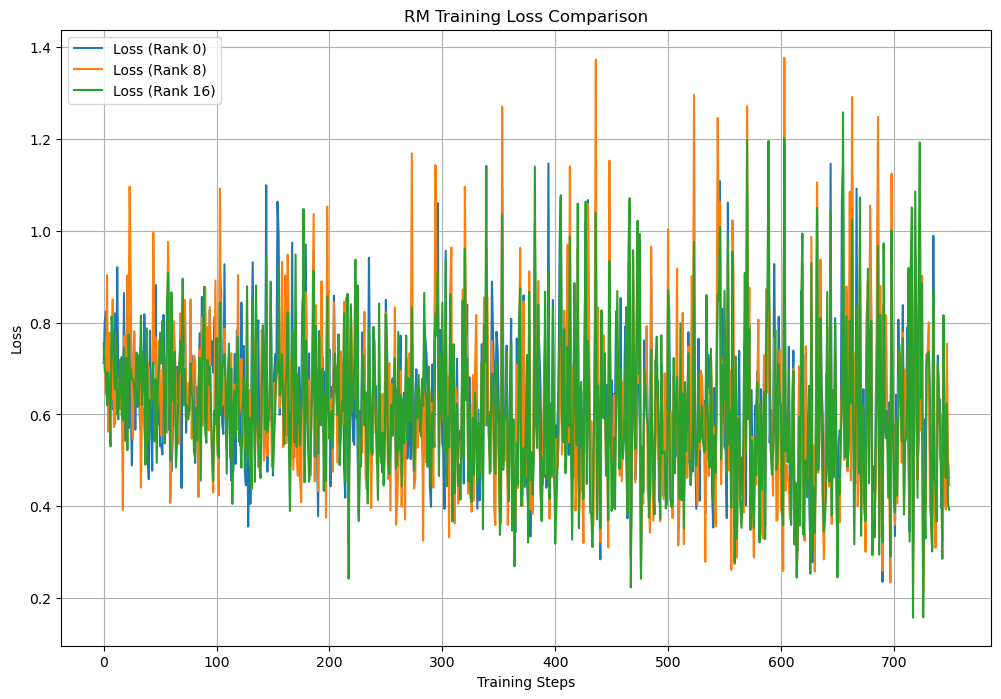

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for lora_rank in LORA_RANKS:
    logs = all_logs.get(lora_rank, [])

    if logs:
        # RewardModelTrainer의 loss_history는 step 정보 없이 loss 값만 리스트로 저장합니다.
        steps = range(len(logs))
        plt.plot(steps, logs, label=f'Loss (Rank {lora_rank})')

plt.title('RM Training Loss Comparison')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 4. 최종 비교 분석

In [8]:
from IPython.display import display, Markdown
import pandas as pd

# 결과를 DataFrame으로 변환하여 더 보기 좋게 출력
data_for_df = []
# chosen_samples, rejected_samples는 실험 루프 셀에서 정의되었다고 가정
num_chosen = len(chosen_samples)

for i, text in enumerate(test_inputs):
    row_data = {}
    row_data['#'] = i + 1
    row_data['Type'] = '좋은 답변 (Chosen)' if i < num_chosen else '나쁜 답변 (Rejected)'

    # 특수문자 처리 및 길이 제한
    snippet = text.replace('\n', ' ').replace('|', ' ')[:50] + '...'
    row_data['Text (Snippet)'] = snippet

    for rank in LORA_RANKS:
        score = all_results.get(rank, [0.0] * len(test_inputs))[i]
        row_data[f'Score (Rank {rank})'] = f'{score:.4f}'

    data_for_df.append(row_data)

# Pandas DataFrame 생성
df = pd.DataFrame(data_for_df)

# DataFrame을 Markdown으로 변환하여 display
markdown_table = df.to_markdown(index=False)

print("--- 최종 비교 분석 ---")
display(Markdown(markdown_table))

--- 최종 비교 분석 ---


|   # | Type                 | Text (Snippet)                                                                                         |   Score (Rank 0) |   Score (Rank 8) |   Score (Rank 16) |
|----:|:---------------------|:-------------------------------------------------------------------------------------------------------|-----------------:|-----------------:|------------------:|
|   1 | 좋은 답변 (Chosen)   | 이 모양은 인물의 얼굴을 나타내는 일러스트레이션 모양입니다. 이 모양은 인물의 얼굴을 나타...            |           0.7306 |           0.08   |            0.2621 |
|   2 | 좋은 답변 (Chosen)   | 1. 사용자 인터페이스가 불편하거나 복잡합니다. 2. 속도가 느립니다. 3. 버그가 많습니...                  |           1.4193 |          -0.2599 |            0.4348 |
|   3 | 좋은 답변 (Chosen)   | 다시 공개한 거 추천해주세요    그러므로 국내 고객의 교육기가 국가적으로 국가한지 국가의...             |           0.1395 |          -0.8229 |           -0.0823 |
|   4 | 좋은 답변 (Chosen)   | 당신은 놀라운 일을 해낼 수 있는 능력을 갖추고 있습니다. 어려움이 있을 수 있지만, 그 ...                |           0.4806 |           0.8351 |            1.1012 |
|   5 | 좋은 답변 (Chosen)   | 요?  마나키 레이카는 다카라즈카 가극단의 공연을 보고 그들의 팬이 되었습니다....                        |           0.0012 |          -0.7571 |           -1.1516 |
|   6 | 좋은 답변 (Chosen)   | 배반도(芭蕃度)이다....                                                                                 |          -0.4868 |          -1.386  |           -0.5189 |
|   7 | 좋은 답변 (Chosen)   | See you again soon....                                                                                 |           0.2756 |          -0.8503 |           -1.6577 |
|   8 | 좋은 답변 (Chosen)   | 테크네튬은 주로 다음과 같은 분야에서 사용됩니다.\n\n1. 의학 분야: 주로 방사성동위원...                 |           1.1197 |          -0.3899 |           -0.0176 |
|   9 | 좋은 답변 (Chosen)   | 국내에서는 개인사회를 강조한 경우 국내에게 발생한 경우 국내에게 발생한 경우 국내에게 발생...           |          -0.1213 |           0.0958 |           -0.3278 |
|  10 | 좋은 답변 (Chosen)   | 가장 큰 보름달은 "초대 보름달"이라고 합니다. 초대 보름달은 지구의 궤도에서 가장 가까운...              |           0.631  |           0.0971 |           -1.0574 |
|  11 | 좋은 답변 (Chosen)   | 젊은 시절보다 결혼적령기가 지나면 결혼 시기를 선택하는 것은 더 어렵습니다. 그러나 그렇다...            |           0.7714 |           0.0017 |            0.6009 |
|  12 | 좋은 답변 (Chosen)   | 제가 AI 언어모델이므로 구체적인 상황을 알려주셔야 제가 더 정확한 답변을 드릴 수 있습니...              |           1.4397 |           0.7045 |            0.5726 |
|  13 | 좋은 답변 (Chosen)   | 물론입니다. 포장 상자에 감사 문구를 첨부해드리겠습니다. 감사합니다!...                                 |           0.8628 |           0.6978 |           -0.3891 |
|  14 | 좋은 답변 (Chosen)   | 제가는 사진을 제공할 수 없습니다. 하지만 양념 안 되어 있는 식재료로는 생선, 닭고기, ...                |           0.4664 |          -0.1568 |           -0.2332 |
|  15 | 좋은 답변 (Chosen)   | 위 한 개인이라는 것을 한 개인이 한 개인이 한 개인이 한 개인이 한 개인이 한 개인이 한...                |          -0.7062 |          -2.0958 |           -1.0369 |
|  16 | 나쁜 답변 (Rejected) | 같이   사라운 것 같다    (사라운 것 같다)...                                                           |           0.0692 |          -1.0438 |           -1.8159 |
|  17 | 나쁜 답변 (Rejected) | 국내 국제국제들이 국제국제들이 국제국제들이 국제국제들이 국제국제들이 국제국제들이 국제국제들...       |          -1.0788 |          -1.8625 |           -1.8482 |
|  18 | 나쁜 답변 (Rejected) | 저는 인공지능 챗봇이므로 실제로 당신과 어울리는 것은 모르겠습니다. 하지만 여러분의 성격,...            |           1.3039 |           0.6053 |            0.9368 |
|  19 | 나쁜 답변 (Rejected) | 잘 하고 있어! 멋진 일을 하고 있어! 더 열심히 하면 더 멋진 결과를 얻을 수 있어! 기...                   |           0.0077 |          -0.0493 |           -0.1155 |
|  20 | 나쁜 답변 (Rejected) | 아버지의 연극을 보고 다카라즈카 가극단의 팬이 되었습니다....                                           |          -0.0974 |          -0.5417 |           -0.466  |
|  21 | 나쁜 답변 (Rejected) | 히데요시 도쿠가와 (秀吉 徳川)입니다....                                                                |          -0.5111 |           0.4063 |            0.7926 |
|  22 | 나쁜 답변 (Rejected) | 안녕! 다음에 또 만나자....                                                                             |           0.035  |          -0.0245 |           -0.5048 |
|  23 | 나쁜 답변 (Rejected) | 개인이 개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개인이개... |          -0.5531 |          -0.1641 |           -1.4288 |
|  24 | 나쁜 답변 (Rejected) | 캐라반을 이용하기 위해서는 먼저 캐라반 사이트에 가입해야 합니다. 가입하기 위해서는 이메일...           |           1.0999 |           0.1721 |           -0.4788 |
|  25 | 나쁜 답변 (Rejected) | 국가미재동영상시간이 개인 기강제동 개인 기강제동의 국가미재동영상을 개인 기강제동의 국가미재...        |          -0.2416 |          -0.9207 |           -0.6523 |
|  26 | 나쁜 답변 (Rejected) | 결혼적령기가 지나면 결혼하기는 가능하지만, 상황에 따라 어려울 수도 있습니다. 예를 들어,...             |           0.0767 |          -0.2249 |           -0.1519 |
|  27 | 나쁜 답변 (Rejected) | 고지서 상에 관리번호를 확인하는 것은 불가능합니다. 관리번호는 수도사업자에서 제공하는 전자...          |           1.5619 |           0.7377 |           -0.237  |
|  28 | 나쁜 답변 (Rejected) | 네, 감사 문구가 있는 포장 상자로 주실 수 있습니다....                                                  |           0.8344 |          -0.2339 |           -1.182  |
|  29 | 나쁜 답변 (Rejected) | 사실, 많은 것들 같은 것입니당. 그런데 그런데 같은 것 같은 것 같은...                                   |           0.4675 |          -0.7647 |           -0.7448 |
|  30 | 나쁜 답변 (Rejected) | 주차는 주차장에 해야 합니다....                                                                        |           0.652  |          -1.1296 |           -0.3508 |